# Modules

In [ ]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision import datasets, transforms

In [ ]:
!pip install syft==0.2.9

In [ ]:
import syft as sy
import torch as th
from torchvision import datasets, transforms

hook = sy.TorchHook(th)

In [ ]:
import numpy as np
import os
from PIL import Image
from torch import nn, optim
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
from random import randrange
import time

# Testing Training for DENSENET

In [ ]:
training_transform = transforms.Compose([
            
                transforms.Resize(size = (256,256)),
                transforms.RandomVerticalFlip(0.1),
                transforms.RandomHorizontalFlip(0.1),
                transforms.RandomRotation(degrees = 10),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

In [ ]:
validation_transform = transforms.Compose([
                                           transforms.Resize(size = (224,224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485],[0.229])
        ])

In [ ]:
trainset = datasets.ImageFolder('/content/drive/MyDrive/chest_xray/train',transform = training_transform)
testset = datasets.ImageFolder('/content/drive/MyDrive/chest_xray/test',transform = validation_transform)
validationset = datasets.ImageFolder('/content/drive/MyDrive/chest_xray/val',transform = validation_transform)

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


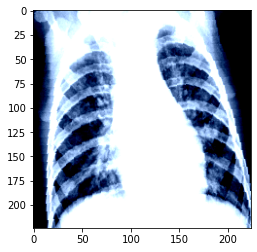

In [ ]:
i = randrange(len(trainset))
print(type(trainset[i][0]))
print(trainset[i][0].shape)
plt.imshow(  trainset[i][0].permute(1, 2, 0)  )

In [ ]:
model = torch.hub.load('pytorch/vision:v0.8.0', 'densenet121', pretrained=False)

Downloading: "https://github.com/pytorch/vision/archive/v0.8.0.zip" to /root/.cache/torch/hub/v0.8.0.zip


In [ ]:
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
trainloader = DataLoader(trainset,batch_size = 64,shuffle = True)
validloader = DataLoader(validationset,batch_size = 64,shuffle = True)
testloader = DataLoader(testset,batch_size = 64,shuffle = True)

In [ ]:
epochs = 5

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/myDenseNetModel")

# Federated Learning

In [63]:
class classify(nn.Module):
    def __init__(self,num_classes=2):
        super(classify,self).__init__()
        
         
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        self.bn1=nn.BatchNorm2d(num_features=12, momentum=0)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32, momentum=0)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=32 * 112 * 112,out_features=num_classes)

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)            
        output=output.view(-1,32*112*112)
        output=self.fc(output)
            
        return output

In [73]:
class Arguments():
    def __init__(self):
        self.batch_size = 1
        self.test_batch_size = 1
        self.epochs = 1
        self.lr = 0.02
        self.seed = 1
        self.log_interval = 5100
        self.precision_fractional = 3

args = Arguments()

th.manual_seed(args.seed)

In [85]:
# Functions to simulate Federated Learning
def connect_to_workers(n_workers):
    return [
        sy.VirtualWorker(hook, id=f"worker{i+1}")
        for i in range(n_workers)
    ]
    
def connect_to_crypto_provider():
    return sy.VirtualWorker(hook, id="crypto_provider")
    
workers = connect_to_workers(n_workers=5) 
crypto_provider = connect_to_crypto_provider()

In [86]:
# Function for secret sharing the data between different workers. NOTE: None of the workers actually see others data.
n_train_items = 10
n_test_items = 10

def get_private_data_loaders(precision_fractional, workers, crypto_provider):
    
    def one_hot_of(index_tensor):
        print(index_tensor)
        num_classes = 2
        onehot_tensor = th.zeros(*index_tensor.shape, num_classes)
        onehot_tensor = onehot_tensor.scatter(1, index_tensor.view(-1, 1), 1)
        return onehot_tensor
        
    def secret_share(tensor):
        return (
            tensor
            .fix_precision(precision_fractional=precision_fractional)
            .share(*workers, crypto_provider=crypto_provider, requires_grad=True)
        )

    training_transform = transforms.Compose([
            
                transforms.Resize(size = (256,256)),
                transforms.RandomVerticalFlip(0.1),
                transforms.RandomHorizontalFlip(0.1),
                transforms.RandomRotation(degrees = 10),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    validation_transform = transforms.Compose([
                                           transforms.Resize(size = (224,224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    print("starting private trainer")
    trainset = datasets.ImageFolder('/content/drive/MyDrive/chest_xray/train',transform = training_transform)
    train_loader = DataLoader(trainset,batch_size = args.batch_size, shuffle = True)
    
    private_train_loader = [
        (secret_share(data), secret_share(one_hot_of(target)))
        for i, (data, target) in enumerate(train_loader)
        if i < n_train_items / args.batch_size
    ]
    
    print("starting private tester")
    testset = datasets.ImageFolder('/content/drive/MyDrive/chest_xray/test',transform = validation_transform)
    test_loader = DataLoader(testset,batch_size = args.test_batch_size, shuffle = True)

    private_test_loader = [
        (secret_share(data), secret_share(target.float()))
        for i, (data, target) in enumerate(test_loader)
        if i < n_test_items / args.test_batch_size
    ]
    
    return private_train_loader, private_test_loader

In [87]:
private_train_loader, private_test_loader = get_private_data_loaders(
    precision_fractional=args.precision_fractional,
    workers=workers,
    crypto_provider=crypto_provider
)

starting private trainer
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
starting private tester


In [88]:
model = classify()

In [89]:
model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

In [90]:
model.parameters

<bound method Module.parameters of classify(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=401408, out_features=2, bias=True)
)>

In [59]:
for batch_idx, (data, target) in enumerate(private_train_loader):
  if batch_idx == 0:
    print(data.get())

(Wrapper)>AutogradTensor>FixedPrecisionTensor>tensor([[[[-2083, -1980, -1861,  ...,  -285,  -285,  -336],
          [-2100, -2015, -1878,  ...,  -354,  -268,  -285],
          [-2032, -1895, -1741,  ...,  -319,  -354,  -354],
          ...,
          [  313,   365,   416,  ..., -2117, -2117, -2117],
          [  296,   330,   382,  ..., -2117, -2117, -2117],
          [  296,   313,   399,  ..., -2117, -2117, -2117]],

         [[-2000, -1895, -1773,  ...,  -162,  -162,  -214],
          [-2018, -1930, -1790,  ...,  -232,  -144,  -162],
          [-1948, -1808, -1650,  ...,  -197,  -232,  -232],
          ...,
          [  450,   502,   555,  ..., -2035, -2035, -2035],
          [  432,   467,   520,  ..., -2035, -2035, -2035],
          [  432,   450,   537,  ..., -2035, -2035, -2035]],

         [[-1769, -1665, -1543,  ...,    60,    60,     8],
          [-1787, -1699, -1560,  ...,    -9,    77,    60],
          [-1717, -1577, -1421,  ...,    25,    -9,    -9],
          ...,
     

In [91]:
# Train Function
def train(args, model, private_train_loader, optimizer, epoch):
    model.train()
    # Private train loader
    for batch_idx, (data, target) in enumerate(private_train_loader):
        print(f"Train Length: {len(data)}")
        start_time = time.time()
        optimizer.zero_grad()
        output = model(data)
        print("Output model received")
        batch_size = output.shape[0]
        loss = ((output - target)**2).sum().refresh()/batch_size
        loss.backward()
        optimizer.step()
        print("Before If statement")

        if batch_idx % args.log_interval == 0:
            loss = loss.get().float_precision()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}s'.format(
                epoch, batch_idx * args.batch_size, len(private_train_loader) * args.batch_size,
                100. * batch_idx / len(private_train_loader), loss.item(), time.time() - start_time))

# Test Function
def test(args, model, private_test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for data, target in private_test_loader:
            start_time = time.time()
            
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum()

    correct = correct.get().float_precision()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct.item(), len(private_test_loader)* args.test_batch_size,
        100. * correct.item() / (len(private_test_loader) * args.test_batch_size)))

In [92]:
model

classify(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=401408, out_features=2, bias=True)
)

In [96]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optimizer.fix_precision() 
criterion = nn.CrossEntropyLoss() 

for epoch in range(1, args.epochs + 1):
    train(args, model, private_train_loader, optimizer, epoch)
    test(args, model, private_test_loader)

Train Length: 1


AssertionError: ignored